In [13]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
os.environ["LOKY_MAX_CPU_COUNT"] = "10"

In [15]:
DATA_PATH = Path("Data/dataset.csv")
df = pd.read_csv(DATA_PATH, low_memory=False)

In [16]:
df = df[df["grav"].notna()]
df = df[df["an_nais"].between(1920, 2023)]
df["age"] = df["year"] - df["an_nais"]

In [17]:
df["catv"] = df["catv"].replace({
    "Motocyclette": "2RM",
    "Scooter_125_cm3": "2RM",
    "Moto_125_cm3": "2RM",
    "Vélo": "Vélo",
    "Voiture": "VP",
    "Quad léger": "Quad",
    "Fourgon": "Utilitaire",
    "Poids lourd 3.5t à 7.5t": "PL",
    "Poids lourd > 7.5t": "PL",
    "Tracteur routier": "PL",
    "Autobus": "Transport",
    "Autocar": "Transport",
    "Engin spécial": "Spécial",
    "Tramway": "Spécial"
})

In [18]:
cols_to_drop = [
    "Num_Acc", "id_usager", "id_vehicule", "num_veh_x", "num_veh_y", "adr",
    "lat", "long", "v1", "v2", "voie", "pr", "pr1", "motor", "occutc", "hrmn"
]
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [19]:
def group_rare_modalities(series, threshold=50):
    counts = series.value_counts()
    rare = counts[counts < threshold].index
    return series.apply(lambda x: "Autre" if x in rare else x)

categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    df[col] = group_rare_modalities(df[col], threshold=50)

In [20]:
selected_cols = [
    "sexe", "catu", "catv", "atm", "lum", "col", "choc",
    "manv", "plan", "surf", "nbv", "secu1", "infra", "place", "age"
]

X = df[selected_cols]
y = df["grav"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

value_counts = pd.Series(y_encoded).value_counts()
valid_classes = value_counts[value_counts >= 2].index
mask = np.isin(y_encoded, valid_classes)

X = X.iloc[mask].reset_index(drop=True)
y_encoded = y_encoded[mask]

le = LabelEncoder()
y_encoded = le.fit_transform(y_encoded)


X_encoded = pd.get_dummies(X.astype(str), drop_first=True)
X_encoded = X_encoded.astype(float)
X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated()]
X_encoded.columns = (
    X_encoded.columns
    .str.replace(r"[\[\]<>\"'{}:|,=]", "", regex=True)
    .str.replace(r"\\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
)

In [21]:
if "age" in X_encoded.columns:
    scaler = StandardScaler()
    X_encoded[["age"]] = scaler.fit_transform(X_encoded[["age"]])

In [22]:
y_binary = (y_encoded == 3).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)
smote = SMOTE(sampling_strategy={3: 30000}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [23]:
X_train_res = pd.DataFrame(X_train_res.values.astype(np.float32), columns=X_train_res.columns)
X_test = pd.DataFrame(X_test.values.astype(np.float32), columns=X_test.columns)

In [24]:
# y_binary = (y_encoded == 3).astype(int)

# X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
#     X_encoded, y_binary, test_size=0.2, stratify=y_binary, random_state=42
# )

# rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
# rf.fit(X_train_rf, y_train_rf)

# Path("Models/RF").mkdir(parents=True, exist_ok=True)
# joblib.dump(rf, "Models/RF/rf_temp.pkl")

              precision    recall  f1-score   support

           0       0.36      0.40      0.38     19966
           1       0.68      0.43      0.53     52472
           2       0.71      0.76      0.74     53818
           3       0.16      0.83      0.27      3385

    accuracy                           0.57    129641
   macro avg       0.48      0.60      0.48    129641
weighted avg       0.63      0.57      0.58    129641



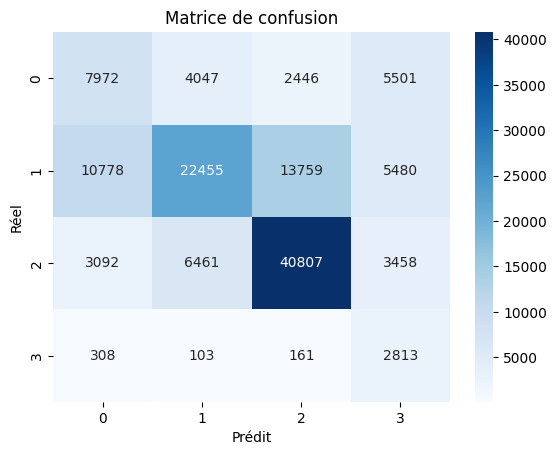

In [25]:
model = joblib.load("Models/Hist/hist_opt.pkl")
le = joblib.load("Models/Hist/label_encoder_opt.pkl")
rf = joblib.load("Models/RF/rf_temp.pkl")
y_pred_main  = model.predict(X_test)

proba_rf = rf.predict_proba(X_test)[:, 1]
seuil = 0.60

y_pred_corrige = []
for y_main, p_rf in zip(y_pred_main, proba_rf):
    if y_main != 3 and p_rf > seuil:
        y_pred_corrige.append(3)
    else:
        y_pred_corrige.append(y_main)


print(classification_report(y_test, y_pred_corrige))

cm = confusion_matrix(y_test, y_pred_corrige)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()